# Working with Numpy FFT Results: Scaling and Folding

Imports
-------

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

Create a Test Signal
--------------------
$f_s$ is the sampling frequency, while $f$ is a base frequency for the signal content. We create a signal that contains components at a couple of multiples of this base frequency. Note the amplitudes here since we will be trying to extract those correctly from the FFT later.

In [2]:
fs = 4*4096.0 # Hz
f   = 15000.0 # Hz
t = np.arange(0.0, 1.0, 1/fs)
i = 1 * np.cos(2 * np.pi * f * t) #+ 2 * np.sin(10 * 2 * np.pi * f * time)
q = 1 * np.sin(2 * np.pi * f * t) #+ 2 * np.sin(10 * 2 * np.pi * f * time)

x = i + 1j*q
x.real = np.int16(x.real/np.max(abs(x.real)) * (2**15 - 1))
x.imag = np.int16(x.imag/np.max(abs(x.imag)) * (2**15 - 1))
print(x)
print(x)


[ 32767.    +0.j  28259.-16586.j  15975.-28608.j ...,   -703.+32759.j
  15975.+28608.j  28259.+16586.j]
[ 32767.    +0.j  28259.-16586.j  15975.-28608.j ...,   -703.+32759.j
  15975.+28608.j  28259.+16586.j]


/usr/lib/python3/dist-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0,0.5,'x')

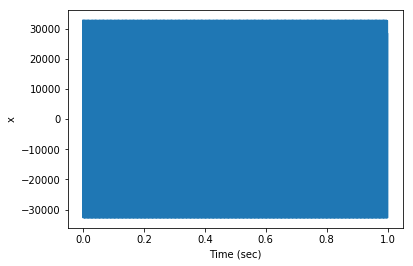

In [3]:
plt.plot(t, x)
plt.xlabel("Time (sec)")
plt.ylabel("x")

In [5]:
from pynq import Overlay

#ol = Overlay('./iotSDR_GPS.bit')
ol = Overlay('./hwfiles/design_1.bit')
list(ol.ip_dict.keys())

fft_data = ol.fft_data_accelerator.axi_dma_data_fft
fft_config = ol.fft_data_accelerator.axi_dma_fft_config


['GPS_Receiver_IQ_Streamer/axi_dma_0',
 'fft_data_accelerator/axi_dma_data_fft',
 'fft_data_accelerator/axi_dma_fft_config',
 'axi_gpio_0',
 'GPS_Receiver_IQ_Streamer/gps_ip_settings',
 'axi_intc_0',
 'processing_system7_0']

In [6]:

from pynq import Xlnk
import numpy as np

xlnk = Xlnk()
def get_config_value(forwards, scaling_sched):
    val = 0
    for scaling in scaling_sched:     # [14:1] = scaling schedule
        val = (val << 2) + scaling
        
    print(hex(val))
    return (val << 1) + int(forwards) # [0] = direction

config_value = get_config_value(True, [2, 2, 2, 2, 2, 2, 2])

fft_buffer_config = xlnk.cma_array(shape=(1,),dtype=np.int16)
fft_buffer_config[0] = config_value
fft_config.sendchannel.transfer(fft_buffer_config)
fft_config.sendchannel.wait()

0x2aaa


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: pynq.Xlnk is deprecated and will be removed in 2.7 - use pynq.allocate instead
  import sys


Compute the FFT
---------------
The FFT and a matching vector of frequencies

In [7]:
def interleave_iq(signal):
    print(signal)
    sig = np.copy(signal)
    i = np.array(sig.real,np.int16)
    q = np.array(sig.imag,np.int16)
    iq = np.concatenate([i,q])
    iq[::2] = i
    iq[1::2] = q
    print(iq)

    return iq

def deinterleave_iq(signal):
    return signal[0::2]+1j*signal[1::2]
      

import time
def fft_hw(signal, NFFT):
    # calculate how many NFFT frames are needed to iterate through entire signal
    #max_iters = np.int16(np.ceil(len(signal)/NFFT)) - 1
    #print(max_iters)
    # calculate amount of zeros to add to make up to NFFT multiple
    #zeros = np.int16(np.ceil(len(signal)/NFFT))*NFFT - len(signal)
    # increase length to multiple of NFFT
    #signal = np.int32(np.append(signal, np.zeros(zeros)))
    
    fft_in_buffer = xlnk.cma_array(shape=(NFFT*2,),dtype=np.int16)
    fft_out_buffer = xlnk.cma_array(shape=(NFFT*2,),dtype=np.int16)
    
    fft_out = np.zeros(len(fft_out_buffer))
    
    #for i in range(0,max_iters):
        #tic = time.time()
    np.copyto(fft_in_buffer,signal[NFFT*0:2*(NFFT*(0+1))])
    tic = time.time()
    fft_data.sendchannel.transfer(fft_in_buffer)
    fft_data.recvchannel.transfer(fft_out_buffer)

    fft_data.sendchannel.wait()
    fft_data.recvchannel.wait()
    toc = time.time()
    fft_out = np.array(fft_out_buffer)

    delta =  "{:.20f}".format((toc-tic)*1000000)
    print("FFT Time(uSec):", delta)
    fft_out_buffer.close()
    fft_in_buffer.close()
    
    return fft_out    

In [8]:
"""plt.plot(t, x)
plt.xlabel("Time (sec)")
plt.ylabel("x")
x_i = interleave_iq(x)
print(x.shape)
x_d = deinterleave_iq(x_i)
"""

'plt.plot(t, x)\nplt.xlabel("Time (sec)")\nplt.ylabel("x")\nx_i = interleave_iq(x)\nprint(x.shape)\nx_d = deinterleave_iq(x_i)\n'

In [9]:
NFFT = 2**14


# only perform FFT over small subset of data
sig_fft_i = interleave_iq(x)
sig_fft = fft_hw(sig_fft_i,NFFT)
# make complex number x[n] + j*x[n+1]
#sig_fft_c = deinterleave_iq(sig_fft)
sig_fft_c = deinterleave_iq(sig_fft)

#sig_fft_c = np.fft.fftshift(sig_fft_c)
print(len(x),len(sig_fft_c))
print(sig_fft_i)
print(sig_fft)
print(sig_fft_c)


[ 32767.    +0.j  28259.-16586.j  15975.-28608.j ...,   -703.+32759.j
  15975.+28608.j  28259.+16586.j]
[32767     0 28259 ..., 28608 28259 16586]
FFT Time(uSec): 812.29209899902343750000
16384 16384
[32767     0 28259 ..., 28608 28259 16586]
[0 0 0 ..., 0 0 0]
[ 0.+0.j  0.+0.j  0.+0.j ...,  0.+0.j  0.+0.j  0.+0.j]


16384


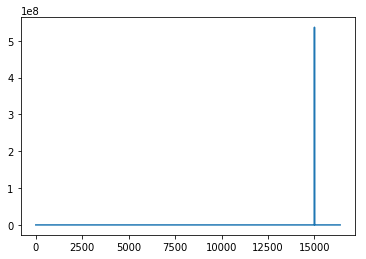

In [10]:

fft_x = np.fft.fft(x)
n = len(fft_x)
print(n)
plt.plot(np.abs(fft_x))

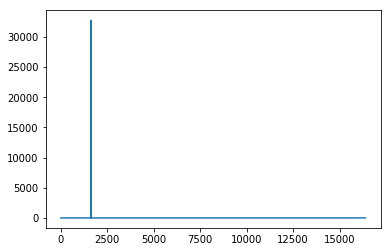

In [11]:
plt.plot(np.abs(sig_fft_c))

Swap Half Spaces
----------------
Note that frequencies in the FFT and the `freq` vector go from zero to some larger positive number then from a large negative number back toward zero. We can swap that so that the DC component is in the center of the vector while maintaining a two-sided spectrum.

In [12]:
freq = np.fft.fftfreq(n, 1/fs)
fft_x_shifted = np.fft.fftshift(sig_fft_c)
freq_shifted = np.fft.fftshift(freq)

Text(0.5,0,'Frequency (Hz)')

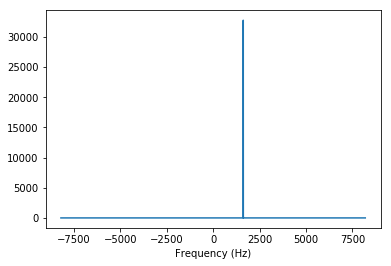

In [13]:
plt.plot(freq_shifted, np.abs(fft_x_shifted))
plt.xlabel("Frequency (Hz)")

Fold Negative Frequencies and Scale
------------------------------
It's actually more common to look at just the first half of the unshifted FFT and frequency vectors and fold all the amplitude information into the positive frequencies. Furthermore, to get ampltude right, we must normalize by the length of the original FFT. Note the factor of $2/n$ in the following which accomplishes both the folding and scaling.

Now the spectrum contains spikes at the correct amplitudes at only positive frequencies, which are the only ones with physicality.